In [1]:
import os
import json
import cv2
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Input
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.losses import binary_crossentropy
from keras.callbacks import Callback, ModelCheckpoint
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf

# os.environ["CUDA_VISIBLE_DEVICES"]='1'

# gpu_options = tf.GPUOptions(allow_growth=True)
# sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) 

ModuleNotFoundError: No module named 'keras'

In [2]:
train_df = pd.read_csv('../input/train.csv')
train_df['ImageId'] = train_df['ImageId_ClassId'].apply(lambda x : x.split('_')[0])
train_df['ClassId'] = train_df['ImageId_ClassId'].apply(lambda x: x.split('_')[1])
train_df['hasMask'] = ~train_df['EncodedPixels'].isna()

print(train_df.shape)
train_df.head()

(50272, 5)


,ImageId_ClassId,EncodedPixels,ImageId,ClassId,hasMask
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...,0002cc93b.jpg,1,True
1,0002cc93b.jpg_2,NaN,0002cc93b.jpg,2,False
2,0002cc93b.jpg_3,NaN,0002cc93b.jpg,3,False
3,0002cc93b.jpg_4,NaN,0002cc93b.jpg,4,False
4,00031f466.jpg_1,NaN,00031f466.jpg,1,False


In [3]:
mask_count_df = train_df.groupby('ImageId').agg(np.sum).reset_index()
mask_count_df.sort_values('hasMask', ascending=False,inplace=True)
print(mask_count_df.shape)
mask_count_df.head()

(12568, 2)


,ImageId,hasMask
10803,db4867ee8.jpg,3.0
11776,ef24da2ba.jpg,3.0
6284,7f30b9c64.jpg,2.0
9421,bf0c81db6.jpg,2.0
9615,c314f43f3.jpg,2.0


In [4]:
# mask_count_df.drop(mask_count_df[mask_count_df['hasMask'] == 0].index.to_list(),inplace=True)
# mask_count_df.reset_index(drop=True,inplace=True)
# print(mask_count_df.shape)
# mask_count_df.head()

In [5]:
sub_df = pd.read_csv('../input/sample_submission.csv')
sub_df['ImageId'] = sub_df['ImageId_ClassId'].apply(lambda x: x.split('_')[0])
test_imgs = pd.DataFrame(sub_df['ImageId'].unique(),columns=['ImageId'])
test_imgs.head()

,ImageId
0,004f40c73.jpg
1,006f39c41.jpg
2,00b7fb703.jpg
3,00bbcd9af.jpg
4,0108ce457.jpg


In [6]:
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    return run length as string formated
    '''
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] +1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle2mask(mask_rls, shape = (256, 1600)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width, heght) of array to return
    return numpy array, 1 - mask, 0 - background
    '''
    s = mask_rls.split()
    starts,lengths = [np.asarray(x,dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

In [7]:
def build_masks(rles, input_shape):
    depth = len(rles)
    height, width = input_shape
    masks = np.zeros((height, width, depth))
    
    for i, rle in enumerate(rles):
        if type(rle) is str:
            masks[:, :, i] = rle2mask(rle, (width, height))
    
    return masks

def build_rles(masks):
    width, height, depth = masks.shape
    
    rles = [mask2rle(masks[:, :, i])
            for i in range(depth)]
    
    return rles

In [8]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

In [9]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, df, target_df=None, mode='fit',
                 base_path='../input/train_images',
                 batch_size=32, dim=(256, 1600), n_channels=3,
                 n_classes=4, random_state=2019, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.df = df
        self.mode = mode
        self.base_path = base_path
        self.target_df = target_df
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.random_state = random_state
        
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_batch = [self.list_IDs[k] for k in indexes]
        
        X = self.__generate_X(list_IDs_batch)
        
        if self.mode == 'fit':
            y = self.__generate_y(list_IDs_batch)
            return X, y
        
        elif self.mode == 'predict':
            return X

        else:
            raise AttributeError('The mode parameter should be set to "fit" or "predict".')
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.seed(self.random_state)
            np.random.shuffle(self.indexes)
    
    def __generate_X(self, list_IDs_batch):
        'Generates data containing batch_size samples'
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        
        # Generate data
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['ImageId'].iloc[ID]
            img_path = f"{self.base_path}/{im_name}"
            img = self.__load_grayscale(img_path)
            
            # Store samples
            X[i,] = img

        return X
    
    def __generate_y(self, list_IDs_batch):
        y = np.empty((self.batch_size, *self.dim, self.n_classes), dtype=int)
        
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['ImageId'].iloc[ID]
            image_df = self.target_df[self.target_df['ImageId'] == im_name]
            
            rles = image_df['EncodedPixels'].values
            masks = build_masks(rles, input_shape=self.dim)
            
            y[i, ] = masks

        return y
    
    def __load_grayscale(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = img.astype(np.float32) / 255.
        img = np.expand_dims(img, axis=-1)

        return img
    
    def __load_rgb(self, img_path):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32) / 255.

        return img

In [10]:
BATCH_SIZE = 32

train_idx, val_idx = train_test_split(
    mask_count_df.index, random_state=2019, test_size=0.15
)

train_generator = DataGenerator(
    train_idx, 
    df=mask_count_df,
    target_df=train_df,
    batch_size=BATCH_SIZE, 
    n_classes=4
)

val_generator = DataGenerator(
    val_idx, 
    df=mask_count_df,
    target_df=train_df,
    batch_size=BATCH_SIZE, 
    n_classes=4
)

In [11]:
# def build_model(input_shape):
#     inputs = Input(input_shape)

#     c1 = Conv2D(8, (3, 3), activation='elu', padding='same') (inputs)
#     c1 = Conv2D(8, (3, 3), activation='elu', padding='same') (c1)
#     p1 = MaxPooling2D((2, 2)) (c1)

#     c2 = Conv2D(16, (3, 3), activation='elu', padding='same') (p1)
#     c2 = Conv2D(16, (3, 3), activation='elu', padding='same') (c2)
#     p2 = MaxPooling2D((2, 2)) (c2)

#     c3 = Conv2D(32, (3, 3), activation='elu', padding='same') (p2)
#     c3 = Conv2D(32, (3, 3), activation='elu', padding='same') (c3)
#     p3 = MaxPooling2D((2, 2)) (c3)

#     c4 = Conv2D(64, (3, 3), activation='elu', padding='same') (p3)
#     c4 = Conv2D(64, (3, 3), activation='elu', padding='same') (c4)
#     p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

#     c5 = Conv2D(64, (3, 3), activation='elu', padding='same') (p4)
#     c5 = Conv2D(64, (3, 3), activation='elu', padding='same') (c5)
#     p5 = MaxPooling2D(pool_size=(2, 2)) (c5)

#     c55 = Conv2D(128, (3, 3), activation='elu', padding='same') (p5)
#     c55 = Conv2D(128, (3, 3), activation='elu', padding='same') (c55)

#     u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c55)
#     u6 = concatenate([u6, c5])
#     c6 = Conv2D(64, (3, 3), activation='elu', padding='same') (u6)
#     c6 = Conv2D(64, (3, 3), activation='elu', padding='same') (c6)

#     u71 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
#     u71 = concatenate([u71, c4])
#     c71 = Conv2D(32, (3, 3), activation='elu', padding='same') (u71)
#     c61 = Conv2D(32, (3, 3), activation='elu', padding='same') (c71)

#     u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c61)
#     u7 = concatenate([u7, c3])
#     c7 = Conv2D(32, (3, 3), activation='elu', padding='same') (u7)
#     c7 = Conv2D(32, (3, 3), activation='elu', padding='same') (c7)

#     u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
#     u8 = concatenate([u8, c2])
#     c8 = Conv2D(16, (3, 3), activation='elu', padding='same') (u8)
#     c8 = Conv2D(16, (3, 3), activation='elu', padding='same') (c8)

#     u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
#     u9 = concatenate([u9, c1], axis=3)
#     c9 = Conv2D(8, (3, 3), activation='elu', padding='same') (u9)
#     c9 = Conv2D(8, (3, 3), activation='elu', padding='same') (c9)

#     outputs = Conv2D(4, (1, 1), activation='sigmoid') (c9)

#     model = Model(inputs=[inputs], outputs=[outputs])
#     model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_coef])
    
#     return model

In [12]:
def build_model(input_shape):
    inputs = Input(input_shape)

    c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (inputs)
    c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
    c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
    c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(64, (3, 3), activation='relu', padding='same') (p4)
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same') (c5)
    p5 = MaxPooling2D(pool_size=(2, 2)) (c5)

    c55 = Conv2D(128, (3, 3), activation='relu', padding='same') (p5)
    c55 = Conv2D(128, (3, 3), activation='relu', padding='same') (c55)

    u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c55)
    u6 = concatenate([u6, c5])
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

    u71 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
    u71 = concatenate([u71, c4])
    c71 = Conv2D(32, (3, 3), activation='relu', padding='same') (u71)
    c61 = Conv2D(32, (3, 3), activation='relu', padding='same') (c71)

    u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c61)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

    u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
    c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

    u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
    c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

    outputs = Conv2D(4, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss=dice_loss, metrics=[dice_coef])
    
    return model

In [13]:
model = build_model((256, 1600, 1))
model.summary()


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 1600, 1) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 1600, 8) 80          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 1600, 8) 584         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 800, 8)  0           conv2d_2[0][0]                 

In [14]:
checkpoint = ModelCheckpoint(
    'model_segmentation_v4_gray_diceloss.h5', 
    monitor='val_dice_coef', 
    verbose=0, 
    save_best_only=True, 
    save_weights_only=True,
    mode='auto'
)

history = model.fit_generator(
    train_generator,
    validation_data=val_generator,
    callbacks=[checkpoint],
    use_multiprocessing=False,
    workers=4,
    epochs=10
)

In [15]:
# with open('history.json', 'w') as f:
#     json.dump(history.history, f)

# history_df = pd.DataFrame(history.history)
# history_df[['loss', 'val_loss']].plot()
# history_df[['dice_coef', 'val_dice_coef']].plot()

In [16]:
# #model.load_weights('model.h5')
# test_df = []

# for i in range(0, test_imgs.shape[0], 500):
#     batch_idx = list(
#         range(i, min(test_imgs.shape[0], i + 500))
#     )
    
#     test_generator = DataGenerator(
#         batch_idx,
#         df=test_imgs,
#         shuffle=False,
#         mode='predict',
#         base_path='../input/test_images',
#         target_df=sub_df,
#         batch_size=1,
#         n_classes=4
#     )
    
#     batch_pred_masks = model.predict_generator(
#         test_generator, 
#         workers=1,
#         verbose=1,
#         use_multiprocessing=False
#     )
    
#     for j, b in tqdm(enumerate(batch_idx)):
#         filename = test_imgs['ImageId'].iloc[b]
#         image_df = sub_df[sub_df['ImageId'] == filename].copy()
        
#         pred_masks = batch_pred_masks[j, ].round().astype(int)
#         pred_rles = build_rles(pred_masks)
        
#         image_df['EncodedPixels'] = pred_rles
#         test_df.append(image_df)

In [17]:
# test_df = pd.concat(test_df)
# test_df.drop(columns='ImageId', inplace=True)
# test_df.to_csv('submission.csv', index=False)

NameError: name 'test_df' is not defined

In [31]:
model.load_weights('model_segmentation_v4_gray.h5')

In [42]:
img_train = cv2.imread('../input/train_images/00031f466.jpg',cv2.IMREAD_GRAYSCALE)
img_train = img_train.astype(np.float32) / 255.
img_train = np.expand_dims(img_train,axis=-1)
img_train_batch = np.zeros((1,256,1600,1))
img_train_batch[0,:] = img_train
mask_train = model.predict(img_train_batch,batch_size=1).round().astype(np.uint8)
mask_train.shape

(1, 256, 1600, 4)

['', '', '252937 3 252941 1 252943 1 252945 1 253191 13 253205 1 253207 1 253209 1 253211 1 253213 1 253445 25 253471 1 253475 1 253700 32 253733 1 253735 1 253955 38 254211 39 254251 1 254467 39 254507 1 254723 41 254979 38 255018 2 255235 40 255491 38 255531 1 255747 38 255786 1 256003 38 256259 37 256515 30 256547 1 256772 29 257028 21 257050 3 257054 1 257284 19 257304 1 257306 1 257545 6 314285 1 314539 3 314787 12 314800 1 315043 14 315059 1 315298 18 315555 18 315575 1 315812 18 316067 15 316083 2 316324 13 316338 1 316580 13 316836 1 316838 1 316840 1 316842 5 316848 1 316850 1', '']


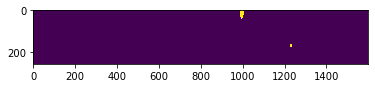

In [43]:
from PIL import Image
import matplotlib.pylab as plt
rle = build_rles(mask_train[0,:])
print(rle)
a = mask_train[0,:,:,2]
img = Image.fromarray(a)
plt.imshow(img)